In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict

# Load the data

In [2]:
meta = pd.read_csv("../data/metadata_filt_180811.csv", index_col=None)
meta = meta.dropna(subset=["PMID"])
meta["PMID"] = meta["PMID"].astype(int)
meta.head(1)

,PMID,DOI,KEY,SOURCE,AUTHORS,YEAR,MONTH,JOURNAL,TITLE,PAGES,VOLUME,ABSTRACT_URL,NUM_COORDINATES,MNI_COORDINATES,BRAINMAP_ID,BEHAVIORAL_DOMAIN,EXPERIMENT,DESCRIPTION
0,1402966,NaN,"Dolan R J, 1992",BrainMap,Dolan R J|Bench C J|Brown R G|Scott L C|Fristo...,1992.0,Sep,"Journal of Neurology, Neurosurgery, and Psychi...",Regional cerebral blood flow abnormalities in ...,768-773,55,http://www.ncbi.nlm.nih.gov/entrez/query.fcgi?...,7.0,"-7.66,51.87,-8.33;-5.51,56.46,-4.28;-5.48,58.9...",6030020.0,"['Action.Rest', 'Action.Rest']","['Unimpaired > Impaired', 'Impaired > Unimpair...",Patients with depression who were cognitively ...


In [105]:
version = 190325
dtm = pd.read_csv("../data/dtm_{}.csv.gz".format(version), 
                  compression="gzip", index_col=0)

## Normalize word counts by article length

In [106]:
doc_lens = {}
for pmid in dtm.index:
    file = "../../../nlp/corpus/{}.txt".format(pmid)
    words = open(file, "r").read().split()
    doc_lens[pmid] = len(words)

In [107]:
dtm_norm = np.empty(dtm.shape)
for i, pmid in enumerate(dtm.index):
    dtm_norm[i,:] = dtm.loc[pmid] / float(doc_lens[pmid])
dtm_norm = pd.DataFrame(dtm_norm, index=dtm.index, columns=dtm.columns)

## Compute mean word proportion by year

In [108]:
years = range(1997, 2018)
prop = pd.DataFrame(index=dtm.columns, columns=years)
for year in years:
    pmids = meta.loc[meta["YEAR"] == year, "PMID"]
    prop[year] = dtm_norm.loc[pmids].mean()

## Combine words by brain system

### Data-driven domains (*k*=7)

In [109]:
kmeans_lists = pd.read_csv("../lists/lists/lists_k07_oplen.csv", index_col=None)

In [110]:
kmeans_doms = [6, 3, 7, 5, 2, 1, 4]
dom2name = {6: "Emotion", 3: "Anticipation", 1: "Meaning", 4: "Language", 
            2: "Manipulation", 5: "Vision", 7: "Cognition"}
kmeans_names = [dom2name[dom] for dom in kmeans_doms]

In [111]:
kmeans_prop = pd.DataFrame(index=kmeans_names, columns=years)
for k, name in zip(kmeans_doms, kmeans_names):
    words = kmeans_lists.loc[kmeans_lists["CLUSTER"] == k, "TOKEN"]
    kmeans_prop.loc[name] = prop.loc[words].mean() * 10000

In [112]:
kmeans_prop.to_csv("data/cogneuro/proportions_kmeans_k07.csv")

### Combined word list

In [113]:
rdoc_lists = pd.read_csv("../lists/lists/lists_rdoc_domain_opsim.csv", index_col=None)
dsm_lists = pd.read_csv("../lists/lists/lists_dsm_class_opsim.csv", index_col=None)

In [114]:
combo_words = sorted(list(set(kmeans_lists["TOKEN"].append(rdoc_lists["TOKEN"].append(dsm_lists["TOKEN"])))))
len(combo_words)

297

# Plot systems over years

In [115]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import warnings
warnings.simplefilter("ignore", UserWarning)
arial = "../style/Arial Unicode.ttf"
% matplotlib inline

In [116]:
prop_sm = font_manager.FontProperties(fname=arial, size=10)
prop_md = font_manager.FontProperties(fname=arial, size=16)
prop_lg = font_manager.FontProperties(fname=arial, size=22)
prop_xlg = font_manager.FontProperties(fname=arial, size=24)
rcParams["axes.linewidth"] = 2

### Data-driven domains (*k*=7)

In [117]:
kmeans_palette = ["#778AA3", # Blue
                  "#B07EB6", # Magenta
                  "#CEBE6D", # Yellow
                  "#77B58A", # Green
                  "#CE7D69", # Red
                  "#7D74A3", # Purple
                  "#BA7E39"] # Orange

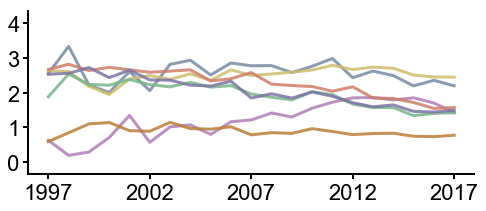

In [118]:
fig, ax = plt.subplots(figsize=(8, 3))

for i, dom in enumerate(kmeans_names):
    plt.plot(years, kmeans_prop.loc[dom], label=dom, 
             c=kmeans_palette[i], alpha=0.85, linewidth=3)

for side in ["right", "top"]:
    ax.spines[side].set_visible(False)

plt.xticks(range(1997,2022,5), fontproperties=prop_lg)
plt.yticks(range(5), fontproperties=prop_lg)

plt.ylim([-0.35, 4.35])

ax.xaxis.set_tick_params(width=2, length=5)
ax.yaxis.set_tick_params(width=2, length=5)

plt.savefig("figures/cogneuro/kmeans/proportions_kmeans_k07.png", 
            dpi=250, bbox_inches="tight")
plt.show()

# Plot word occurrences

#### Observed values

In [119]:
kmeans_words = list(set(kmeans_lists["TOKEN"]))
len(kmeans_words)

109

In [120]:
kmeans_prop = np.mean(dtm_norm[kmeans_words], axis=0) * 10000
print(kmeans_prop.sort_values(ascending=False)[:10])

word              11.550334
face              10.233911
memory             7.990339
cognitive          7.754776
movement           7.683808
attention          6.665140
pain               6.431386
action             6.223179
representation     5.575358
hand               5.479582
dtype: float64


In [121]:
kmeans_dtm_norm = dtm_norm[kmeans_words].values
combo_dtm_norm = dtm_norm[combo_words].values

#### Bootstrap distributions

In [122]:
n_iter = 10000

In [123]:
words_prop_boot = np.empty((len(kmeans_words), n_iter))
for n in range(n_iter):
    boot = np.random.choice(range(len(kmeans_dtm_norm)), size=len(kmeans_dtm_norm), replace=True)
    words_prop_boot[:,n] = np.mean(kmeans_dtm_norm[boot,:], axis=0) * 10000

In [133]:
tot_prop_boot = np.empty((n_iter))
for n in range(n_iter):
    boot = np.random.choice(range(len(combo_dtm_norm)), size=len(combo_dtm_norm), replace=True)
    tot_prop_boot[n] = np.mean(np.mean(combo_dtm_norm[boot,:], axis=0)) * 10000

#### Comparison tests

In [134]:
from statsmodels.stats import multitest

In [135]:
pval = []
df = pd.DataFrame()
kmeans_mean = np.mean(tot_prop_boot)
for i, word in enumerate(kmeans_words):   
    word_boot = words_prop_boot[i,:]
    if np.mean(word_boot) > kmeans_mean:
        p = np.sum(np.less(word_boot, np.max(tot_prop_boot))) / float(n_iter)
    else:
        p = 1 # np.sum(np.less(dom_not, np.max(dom_rdoc))) / float(n_iter)
    pval.append(p)
    df.loc[word, "P"] = p
df["P_COR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for word in kmeans_words:
    for star, alpha in zip(["*", "**", "***"], [0.05, 0.01, 0.001]):
        if df.loc[word, "P_COR"] < alpha:
            df.loc[word, "STARS"] = star
df = df.loc[kmeans_words, ["P", "P_COR", "STARS"]]
df.sort_values("P")[:10]

,P,P_COR,STARS
working_memory,0.0,0.0,***
facial_expression,0.0,0.0,***
noise,0.0,0.0,***
attention,0.0,0.0,***
hand,0.0,0.0,***
language,0.0,0.0,***
fear,0.0,0.0,***
context,0.0,0.0,***
emotion,0.0,0.0,***
reaction_time,0.0,0.0,***


#### Distribution plots

In [136]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import warnings
warnings.simplefilter("ignore", UserWarning)
% matplotlib inline

In [137]:
arial = "../style/Arial Unicode.ttf"
prop_sm = font_manager.FontProperties(fname=arial, size=18)
prop_md = font_manager.FontProperties(fname=arial, size=20)
prop_lg = font_manager.FontProperties(fname=arial, size=24)
rcParams["axes.linewidth"] = 1.5

In [138]:
kmeans_palette = ["#778AA3", # Blue
                  "#B07EB6", # Magenta
                  "#CEBE6D", # Yellow
                  "#77B58A", # Green
                  "#CE7D69", # Red
                  "#7D74A3", # Purple
                  "#BA7E39"] # Orange

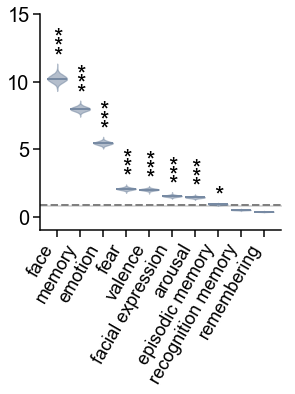

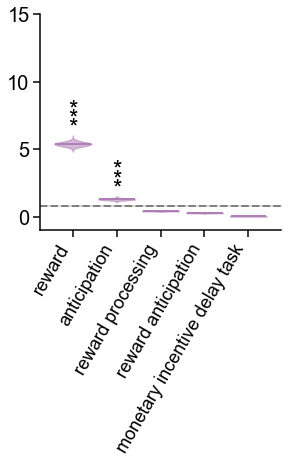

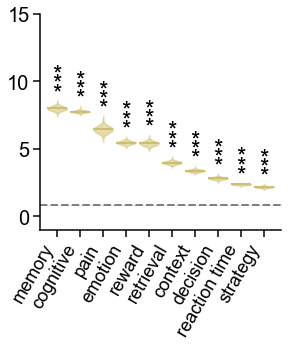

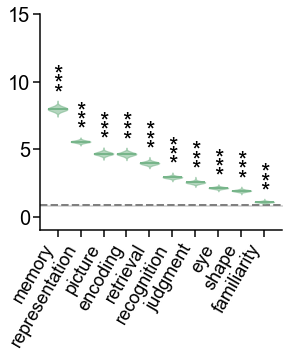

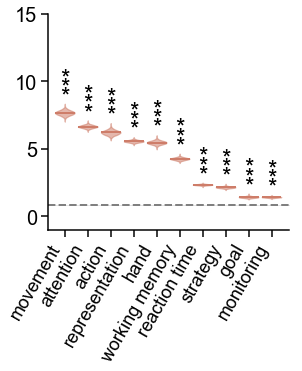

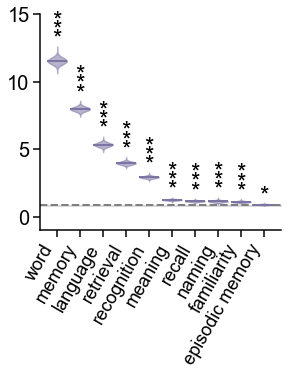

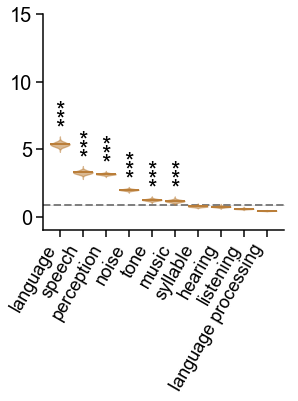

In [166]:
ymax = [15]*7
dxs = [0.42, 0.36, 0.45, 0.45, 0.45, 0.45, 0.45]
for d, dom in enumerate(kmeans_doms):  
    
    # Extract and sort words
    dom_words = set(kmeans_lists.loc[kmeans_lists["CLUSTER"] == dom, "TOKEN"])
    dom_words = dom_words.intersection(kmeans_prop.index)
    dom_words = list(kmeans_prop.loc[dom_words].sort_values(ascending=False).index)[:10]
    
    # Set up figure
    fig = plt.figure(figsize=(3.35, 3))
    ax = fig.add_axes([0,0,1,1])
    
    # Mean as line plot
    xs = range(-1, len(dom_words)+1)
    data = sorted(list(tot_prop_boot))
    plt.plot(xs, [np.mean(data)] * len(xs), "gray", 
             linestyle="dashed", linewidth=2, zorder=-100)
    plt.fill_between(xs, data[int(float(n_iter)*0.001)], y2=data[int(float(n_iter)*0.999)], 
                     color="gray", alpha=0.2, zorder=-100)

    
    for i, word in enumerate(dom_words):
        idx = kmeans_words.index(word)
        
        # Violin plot
        data = sorted(words_prop_boot[idx,:])
        obs = kmeans_prop.loc[word]
        plt.plot([i-0.63, i+0.14], [obs, obs], 
                 c=kmeans_palette[d], alpha=1, lw=2)
        v = ax.violinplot(data, positions=[i-0.25], 
                          showmeans=False, showmedians=False, widths=0.85)
        for pc in v["bodies"]:
            pc.set_facecolor(kmeans_palette[d])
            pc.set_edgecolor(kmeans_palette[d])
            pc.set_linewidth(1.25)
            pc.set_alpha(0.55)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")

        # Comparison test
        alphas = [0.05, 0.01, 0.001]
        dys = [0.0, float(ymax[d])/22.0, float(ymax[d])/11.0]
        for alpha, dy in zip(alphas, dys):
            if df.loc[word, "P_COR"] < alpha:
                plt.text(i-dxs[d], max(data) + dy, "*", fontproperties=prop_lg)
    
    # Set plot parameters
    plt.xticks([v-0.25 for v in range(len(dom_words))], 
               fontproperties=prop_sm)
    ax.set_xticklabels([w.replace("_", " ") for w in dom_words], 
                       rotation=60, ha="right")
    plt.yticks(range(0, ymax[d]+5, 5), fontproperties=prop_md)
    plt.xlim([-1, len(dom_words)-0.5])
    plt.ylim([-1, ymax[d]]) 
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.yaxis.set_tick_params(width=1.5, length=7)

    # Export figure
    plt.savefig("figures/cogneuro/kmeans/{}_{}iter.png".format(kmeans_names[d].upper(), n_iter), 
                dpi=250, bbox_inches="tight")
    plt.show()

## Plot occurrences over years

In [155]:
kmeans_prop_yr = pd.DataFrame(index=dtm_norm.columns, columns=years)
for year in years:
    pmids = set(meta.loc[meta["YEAR"] == year, "PMID"])
    kmeans_prop_yr[year] = dtm_norm.loc[pmids].mean() * 10000

EMOTION


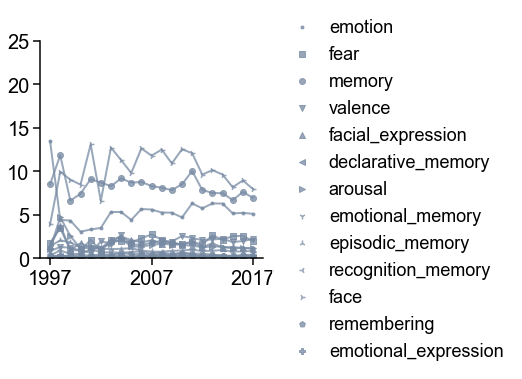

ANTICIPATION


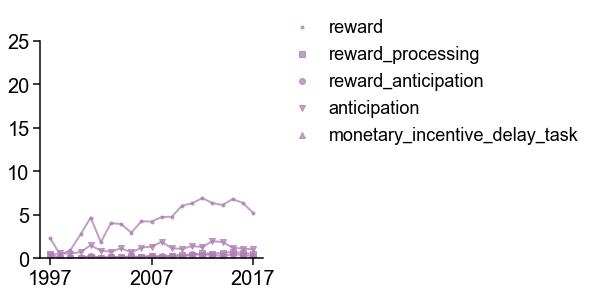

COGNITION


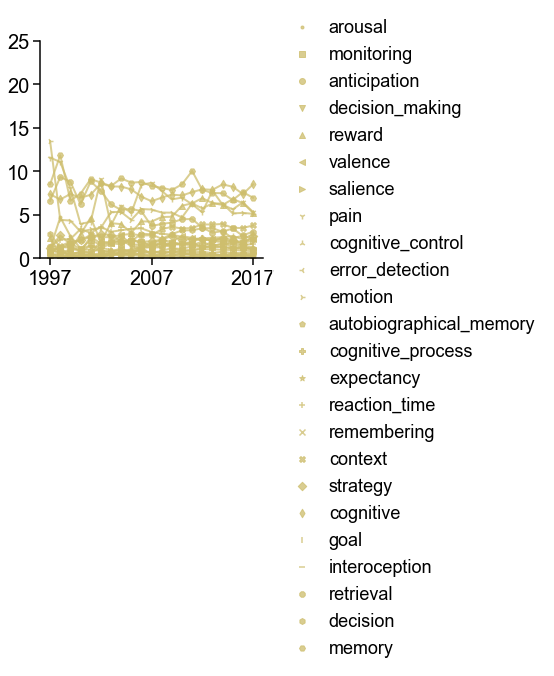

VISION


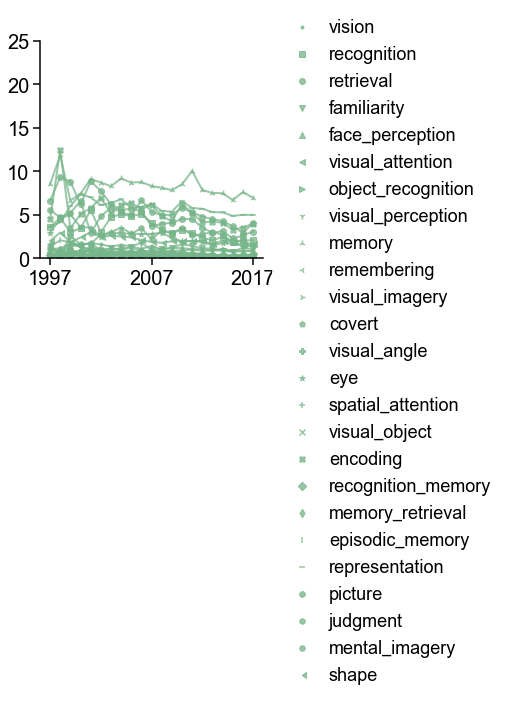

MANIPULATION


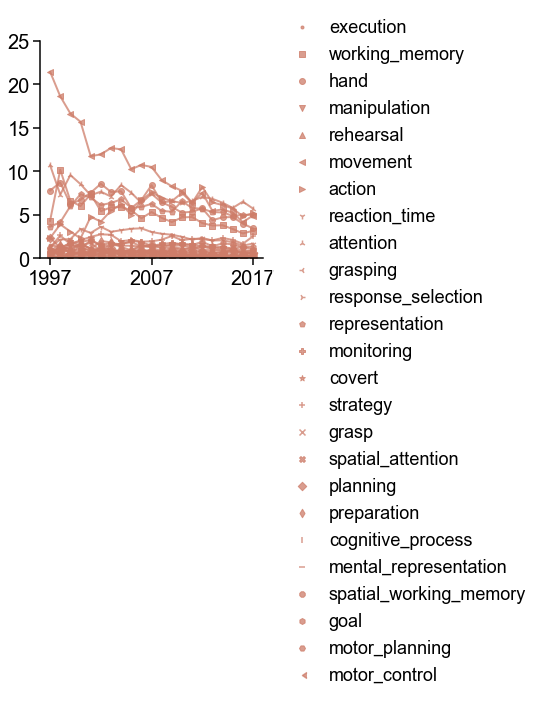

MEANING


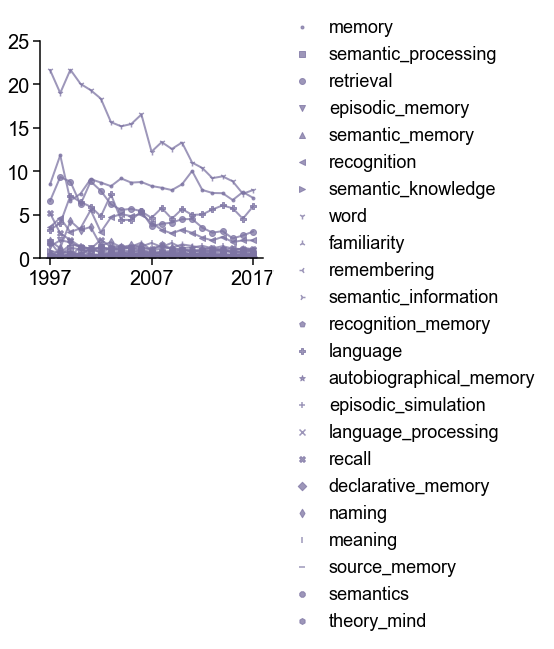

LANGUAGE


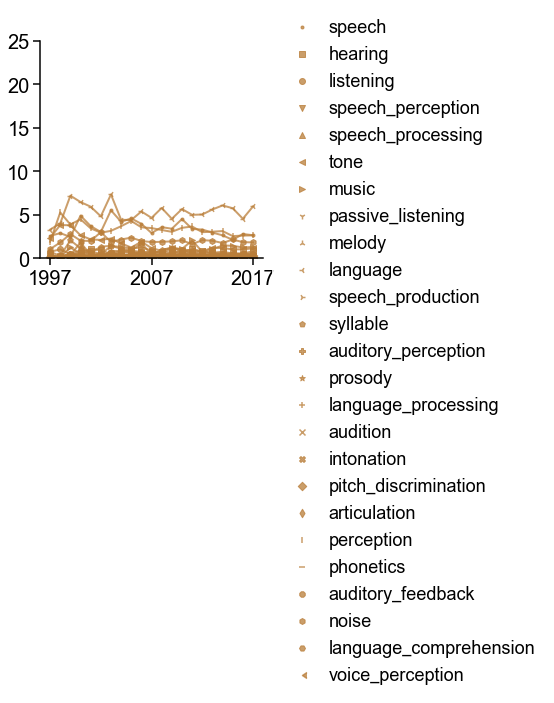

In [171]:
ymax = [25]*7
markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", 
           "p", "P", "*", "+", "x", "X", "D", "d", "|", "_", "8",
           "h", "H", 4, 5]
for i, dom in enumerate(kmeans_doms):
    fig, ax = plt.subplots(figsize=(4, 4))
    words = kmeans_lists.loc[kmeans_lists["CLUSTER"] == dom, "TOKEN"]
    for j, word in enumerate(words):
        plt.scatter(years, kmeans_prop_yr.loc[word], label=word, 
                    c=kmeans_palette[i], alpha=0.75, marker=markers[j])
    ax.legend(loc="upper left", prop=prop_sm, edgecolor="white", 
              handletextpad=0.5, borderpad=0.65, bbox_to_anchor=(1, 1.2))
    
    for j, word in enumerate(words):
        plt.plot(years, kmeans_prop_yr.loc[word], zorder=0,
                 c=kmeans_palette[i], alpha=0.75, linewidth=2)
        
    for side in ["right", "top"]:
        ax.spines[side].set_visible(False)
    plt.xlim([1996,2018])
    plt.xticks(range(1997,2022,10), fontproperties=prop_md)
    plt.ylim([0, ymax[i]])
    plt.yticks(range(0, ymax[i]+5, 5), fontproperties=prop_md)

    ax.xaxis.set_tick_params(width=1.5, length=7)
    ax.yaxis.set_tick_params(width=1.5, length=7)
    
    name = kmeans_names[i].upper()
    print(name)
    plt.savefig("figures/cogneuro/kmeans/{}_years.png".format(name), 
                dpi=250, bbox_inches="tight")
    plt.show()